# Importing Libraries

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## Step 1: Load & Clean Data

In [ ]:

import pandas as pd
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)

df = df.dropna()

# Rename columns
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'})

df = df[df.Location.isin(['Melbourne', 'MelbourneAirport', 'Watsonia'])]


df.head()
print(df)


             Date          Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
64191  2009-01-01  MelbourneAirport     11.2     19.9       0.0          5.6   
64192  2009-01-02  MelbourneAirport      7.8     17.8       1.2          7.2   
64193  2009-01-03  MelbourneAirport      6.3     21.1       0.0          6.2   
64194  2009-01-04  MelbourneAirport      8.1     29.2       0.0          6.4   
64195  2009-01-05  MelbourneAirport      9.7     29.0       0.0          7.4   
...           ...               ...      ...      ...       ...          ...   
80992  2017-06-20          Watsonia      3.6     14.5       0.0          2.4   
80994  2017-06-22          Watsonia      4.8     13.3       0.4          0.6   
80995  2017-06-23          Watsonia      5.6     13.1       0.0          1.6   
80996  2017-06-24          Watsonia      6.9     12.1       3.2          1.8   
80997  2017-06-25          Watsonia      7.9     13.0       0.0          2.8   

       Sunshine WindGustDir  WindGustSp

## Step 2: Feature Engineering

In [ ]:

def date_to_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df = df.drop(columns='Date')

X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

## Step 3: Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Step 4: Preprocessing

In [ ]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Step 5: Random Forest

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

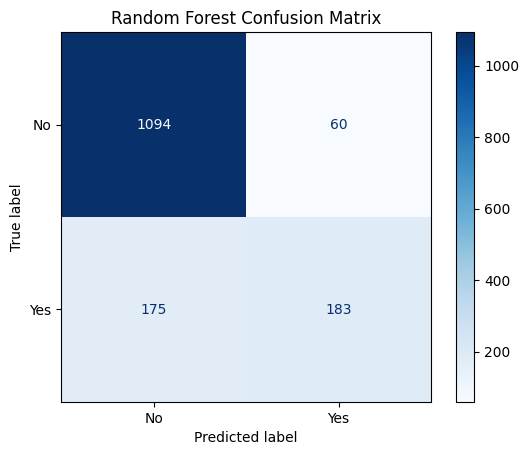

In [ ]:

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=cv, scoring='accuracy', verbose=2)
rf_grid.fit(X_train, y_train)

print("\nRandom Forest Best Params:", rf_grid.best_params_)
print("Random Forest Test Accuracy:", rf_grid.score(X_test, y_test))
y_pred_rf = rf_grid.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

## Step 6: Logistic Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

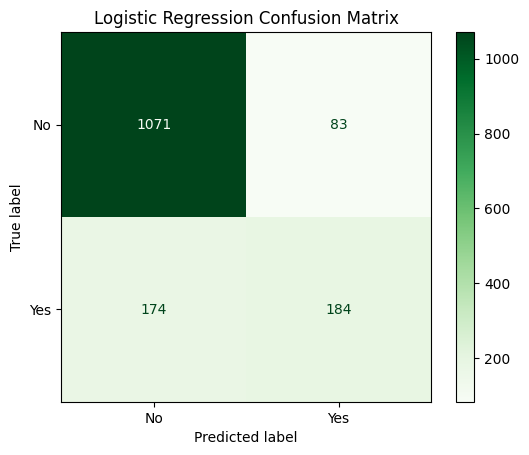

In [ ]:


lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

lr_params = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=cv, scoring='accuracy', verbose=2)
lr_grid.fit(X_train, y_train)

print("\nLogistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Test Accuracy:", lr_grid.score(X_test, y_test))
y_pred_lr = lr_grid.predict(X_test)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## Step 7: SVM

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=   3.8s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=   4.0s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=   3.4s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=   3.4s
[CV] END .......classifier__C=0.1, classifier__kernel=linear; total time=   4.3s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=   5.1s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=   5.9s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=   5.3s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=   5.3s
[CV] END ..........classifier__C=0.1, classifier__kernel=rbf; total time=   5.9s
[CV] END .........classifier__C=1, classifier__kernel=linear; total time=   6.0s
[CV] END .........classifier__C=1, classifier__ke

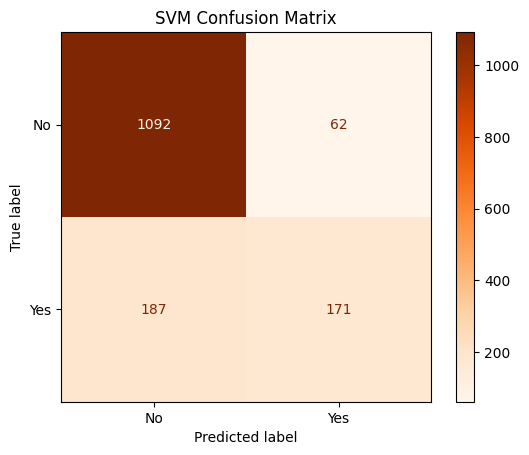

In [ ]:

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=cv, scoring='accuracy', verbose=2)
svm_grid.fit(X_train, y_train)

print("\nSVM Best Params:", svm_grid.best_params_)
print("SVM Test Accuracy:", svm_grid.score(X_test, y_test))
y_pred_svm = svm_grid.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap='Oranges')
plt.title("SVM Confusion Matrix")
plt.show()

## Step 8: KNN

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.1s
[CV] END classifier__n_neighbors=3, classifier__weights=distance; total time=   0.1s
[CV] END classifier__n_neighbors=5, classifier__weights=uniform; total time=   0.1s
[CV] END cl

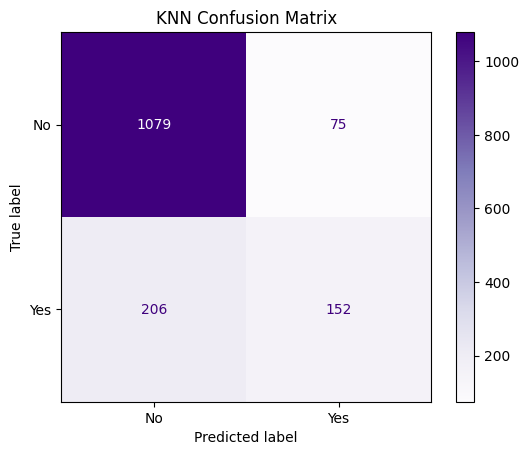

In [ ]:

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

knn_params = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=cv, scoring='accuracy', verbose=2)
knn_grid.fit(X_train, y_train)

print("\nKNN Best Params:", knn_grid.best_params_)
print("KNN Test Accuracy:", knn_grid.score(X_test, y_test))
y_pred_knn = knn_grid.predict(X_test)

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap='Purples')
plt.title("KNN Confusion Matrix")
plt.show()

## Step 9: Gradient Boosting

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.3s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.3s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   3.7s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   4.5s
[CV] END classifier_

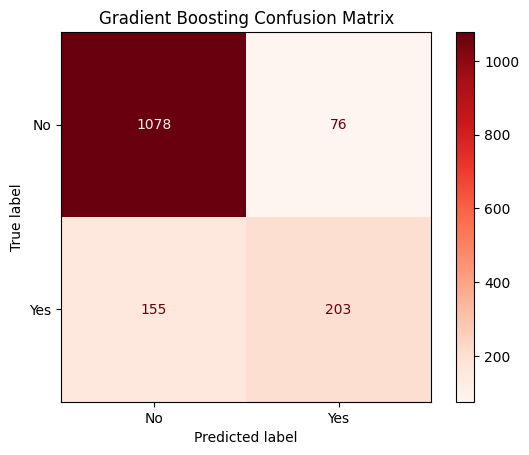

In [ ]:

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5]
}

gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=cv, scoring='accuracy', verbose=2)
gb_grid.fit(X_train, y_train)

print("\nGradient Boosting Best Params:", gb_grid.best_params_)
print("Gradient Boosting Test Accuracy:", gb_grid.score(X_test, y_test))
y_pred_gb = gb_grid.predict(X_test)

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap='Reds')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


## Step 10: XGBoost

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   1.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:45:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
XGBoost Test Accuracy: 0.8478835978835979

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1154
           1       0.75      0.54      0.63       358

    accuracy                           0.85      1512
   macro avg       0.81      0.74      0.77      1512
weighted avg       0.84      0.85      0.84      1512



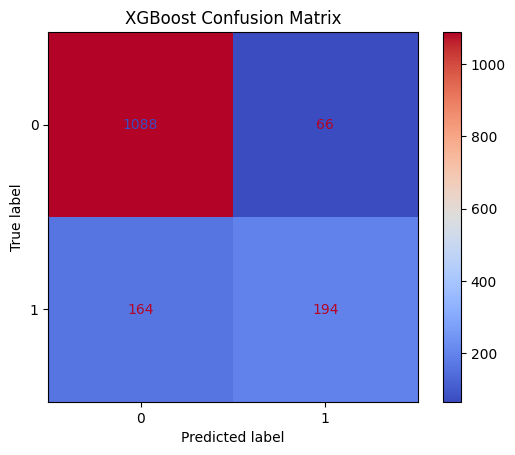

In [ ]:
# Step 11: XGBoost Classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1]
}

# Encode the target variable
y_train_encoded = y_train.apply(lambda x: 1 if x == 'Yes' else 0)
y_test_encoded = y_test.apply(lambda x: 1 if x == 'Yes' else 0)

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=cv, scoring='accuracy', verbose=2)
xgb_grid.fit(X_train, y_train_encoded)

print("\nXGBoost Best Params:", xgb_grid.best_params_)
print("XGBoost Test Accuracy:", xgb_grid.score(X_test, y_test_encoded))
y_pred_xgb = xgb_grid.predict(X_test)

print("\nXGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb))

ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_xgb, cmap='coolwarm')
plt.title("XGBoost Confusion Matrix")
plt.show()

## Step 11: ROC Comparison

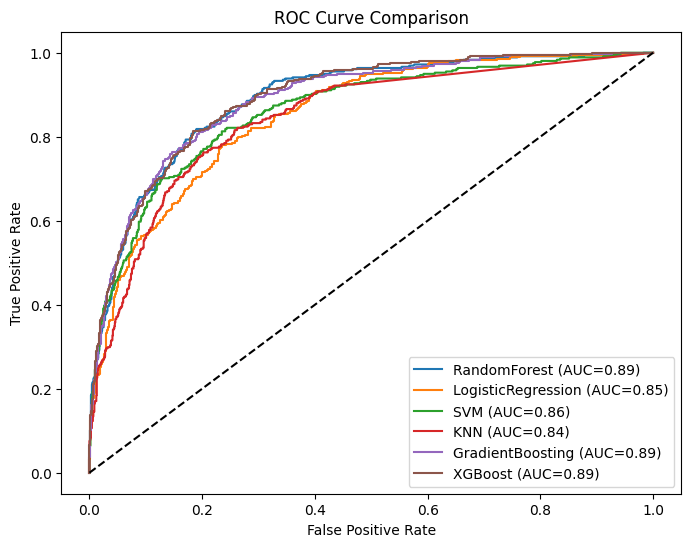

In [ ]:

plt.figure(figsize=(8,6))

for name, grid in {
    'RandomForest': rf_grid,
    'LogisticRegression': lr_grid,
    'SVM': svm_grid,
    'KNN': knn_grid,
    'GradientBoosting': gb_grid,
    'XGBoost': xgb_grid
}.items():
    y_prob = grid.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test.map({'No':0, 'Yes':1}), y_prob)
    auc = roc_auc_score(y_test.map({'No':0, 'Yes':1}), y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

## Step 12: Model Comparison Summary

In [ ]:
from sklearn.metrics import accuracy_score

models = {
    "RandomForest": rf_grid,
    "LogisticRegression": lr_grid,
    "SVM": svm_grid,
    "KNN": knn_grid,
    "GradientBoosting": gb_grid,
    "XGBoost": xgb_grid
}

print("✅ Model Comparison Summary:\n")
print(f"{'Model':<20} {'Test Accuracy':<15} {'Best Params'}")
print("-"*70)

for name, grid in models.items():
    y_pred = grid.predict(X_test)
    y_pred_encoded = [1 if pred == 'Yes' else 0 for pred in y_pred] # Encode predictions
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
    print(f"{name:<20} {accuracy:<15.4f} {grid.best_params_}")

# Optional: Compare AUCs too
print("\nAUC Scores:")
print(f"{'Model':<20} {'AUC':<10}")
print("-"*30)
for name, grid in models.items():
    y_prob = grid.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test_encoded, y_prob)
    print(f"{name:<20} {auc:<10.4f}")

✅ Model Comparison Summary:

Model                Test Accuracy   Best Params
----------------------------------------------------------------------
RandomForest         0.8446          {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
LogisticRegression   0.8300          {'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
SVM                  0.8353          {'classifier__C': 1, 'classifier__kernel': 'rbf'}
KNN                  0.8142          {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
GradientBoosting     0.8472          {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
XGBoost              0.7632          {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

AUC Scores:
Model                AUC       
------------------------------
RandomForest         0.8884    
LogisticRegress

In [ ]:

print("✅ Exercises & Concepts Covered in This Project:")
print("1. Data loading, cleaning, and filtering")
print("2. Feature engineering (Date → Season)")
print("3. Train-test split with stratification")
print("4. Preprocessing pipelines (scaling + encoding)")
print("5. Model building and hyperparameter tuning for:")
print("   - Random Forest, Logistic Regression, SVM, KNN, Gradient Boosting, XGBoost")
print("6. Model evaluation with accuracy, classification report, confusion matrices")
print("7. Probabilistic evaluation with ROC curves and AUC")
print("8. Model comparison and visualization")
print("9. End-to-end ML workflow implementation")



✅ Exercises & Concepts Covered in This Project:
1. Data loading, cleaning, and filtering
2. Feature engineering (Date → Season)
3. Train-test split with stratification
4. Preprocessing pipelines (scaling + encoding)
5. Model building and hyperparameter tuning for:
   - Random Forest, Logistic Regression, SVM, KNN, Gradient Boosting, XGBoost
6. Model evaluation with accuracy, classification report, confusion matrices
7. Probabilistic evaluation with ROC curves and AUC
8. Model comparison and visualization
9. End-to-end ML workflow implementation


In [ ]:
print("\n💡 Final Takeaways:")
print("1. Random Forest, Gradient Boosting, and XGBoost generally perform best on tabular classification data.")
print("2. Logistic Regression and SVM are simpler models, good for baseline comparison.")
print("3. KNN can be sensitive to feature scaling and data size; careful tuning is needed.")
print("4. Using pipelines + GridSearchCV ensures reproducible preprocessing and hyperparameter optimization.")
print("5. ROC-AUC provides a probabilistic performance comparison beyond simple accuracy.")
print("6. This workflow can be adapted for other real-world tabular datasets with minimal changes.")



💡 Final Takeaways:
1. Random Forest, Gradient Boosting, and XGBoost generally perform best on tabular classification data.
2. Logistic Regression and SVM are simpler models, good for baseline comparison.
3. KNN can be sensitive to feature scaling and data size; careful tuning is needed.
4. Using pipelines + GridSearchCV ensures reproducible preprocessing and hyperparameter optimization.
5. ROC-AUC provides a probabilistic performance comparison beyond simple accuracy.
6. This workflow can be adapted for other real-world tabular datasets with minimal changes.
